# Progetto d'esame di Data Analysis in Experimental Physics with Machine Learning

Gruppo composto dagli studenti Luca Attinà, Sharis Feriotto e Matteo Marchisio Caprioglio

Ipotesi dataset iniziale: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

Questo dataset non va bene perchè ha fatto data aug sul validation dataset, fallback al plant village originale: https://www.tensorflow.org/datasets/catalog/plant_village

In [13]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
import os
import sys
sys.path.append('./src')
import pandas as pd
import random

# from tqdm.notebook import tqdm


In [14]:
print(tf.config.list_physical_devices('GPU'))


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
# Seed setting for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)


In [16]:
# Load the PlantVillage dataset from TFDS instead of the new dataset (it performed data aug on the validation set, which is wrong)
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'plant_village',
    split=['train[:80%]', 'train[80%:95%]', 'train[95%:]'],
    # shuffle_files=True,
    as_supervised=True,  # returns (image, label) pairs
    with_info=True
)


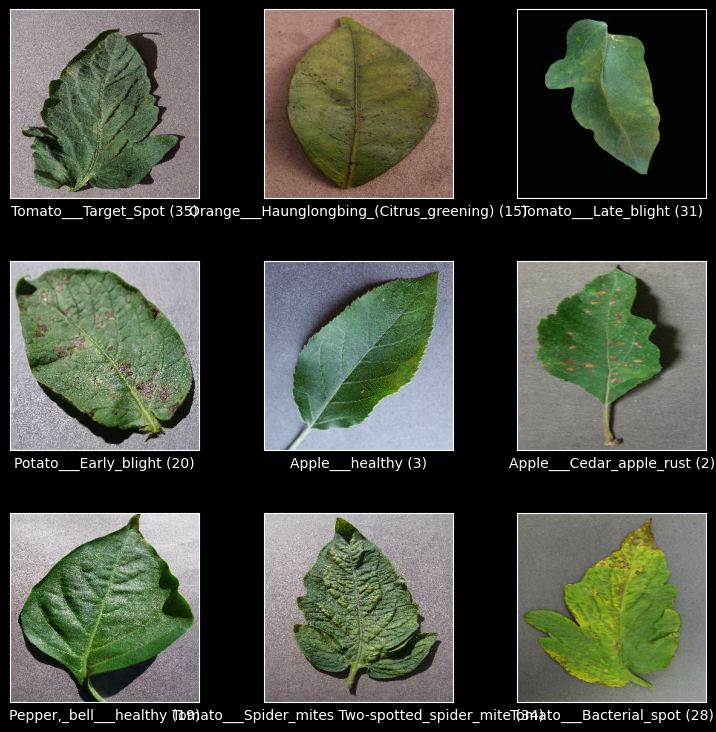

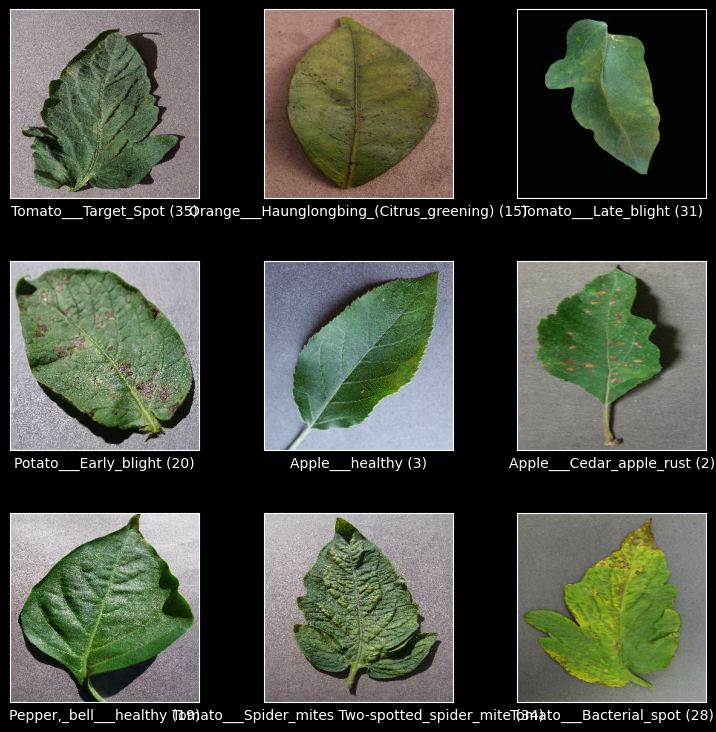

In [17]:
# Show example from the dataset
tfds.show_examples(ds_train, ds_info)


In [18]:
# Extract only labels (not images) for counting
labels_list = []
for _, label in ds_train:
    labels_list.append(label.numpy())

# Convert to pandas Series for fast operations
labels_series = pd.Series(labels_list)

number_of_classes = ds_info.features['label'].num_classes
print(f"Number of classes: {number_of_classes}")
class_names = ds_info.features['label'].names

# Count using pandas (fast) but memory-efficient
class_counts = labels_series.value_counts().sort_index()

# Print the counts with class names
print("Number of images per class:")
for idx, count in class_counts.items():
    print(f"{class_names[idx]}: {count} images")


Number of classes: 38
Number of images per class:
Apple___Apple_scab: 501 images
Apple___Black_rot: 467 images
Apple___Cedar_apple_rust: 221 images
Apple___healthy: 1306 images
Blueberry___healthy: 1210 images
Cherry___healthy: 659 images
Cherry___Powdery_mildew: 851 images
Corn___Cercospora_leaf_spot Gray_leaf_spot: 405 images
Corn___Common_rust: 953 images
Corn___healthy: 939 images
Corn___Northern_Leaf_Blight: 788 images
Grape___Black_rot: 956 images
Grape___Esca_(Black_Measles): 1111 images
Grape___healthy: 349 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 881 images
Orange___Haunglongbing_(Citrus_greening): 4399 images
Peach___Bacterial_spot: 1838 images
Peach___healthy: 292 images
Pepper,_bell___Bacterial_spot: 800 images
Pepper,_bell___healthy: 1173 images
Potato___Early_blight: 792 images
Potato___healthy: 122 images
Potato___Late_blight: 801 images
Raspberry___healthy: 302 images
Soybean___healthy: 4043 images
Squash___Powdery_mildew: 1466 images
Strawberry___healthy: 353

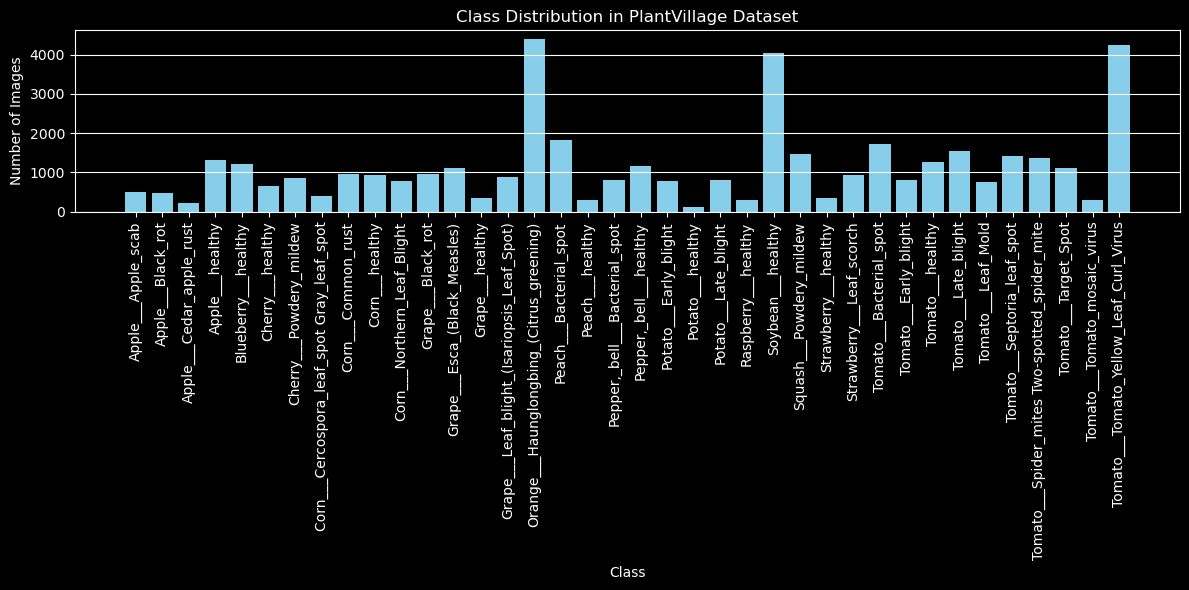

In [19]:
# Visualize the class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_names, class_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in PlantVillage Dataset')
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# Useful constants
IMG_SIZE = (128, 128)  # Image size for the model
BATCH_SIZE = 32


In [ ]:
from preprocessing import preprocess

train_ds = ds_train.map(lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds   = ds_val.map  (lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds  = ds_test.map (lambda image, label: preprocess(image, label, ds_info, IMG_SIZE), num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Activation, BatchNormalization, Dense, Conv2D, MaxPooling2D, Dropout, Flatten, GlobalAveragePooling2D, ReLU, Rescaling
from keras.optimizers.legacy import Adam, SGD
from keras.losses import CategoricalCrossentropy

from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


def simple_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=38):
    model = Sequential([
        Conv2D(16, (3, 3), activation='relu', padding='same'),
        Dropout(0.4),
        MaxPooling2D((2, 2)),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(num_classes, activation='softmax')
    ])
    return model


In [24]:
model = simple_cnn()
model.build(input_shape=(None, IMG_SIZE[0], IMG_SIZE[1], 3))  # Build the model with the input shape
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 16)      448       
                                                                 
 dropout_2 (Dropout)         (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 32768)            

In [25]:
optimizer = Adam(learning_rate=0.0002)
# optimizer = SGD(learning_rate=0.05, momentum=0.9)
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(),
    metrics=['accuracy']
)

n_epochs = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=n_epochs,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('./weights/base_model.h5', monitor='val_loss', save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
    ]
)


Epoch 1/30
   1/1358 [..............................] - ETA: 6:32 - loss: 3.6016 - accuracy: 0.1250

2025-07-21 15:59:28.771001: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1358/1358 [==============================] - 22s 16ms/step - loss: 1.8776 - accuracy: 0.5050 - val_loss: 1.2473 - val_accuracy: 0.6581 - lr: 2.0000e-04
Epoch 2/30
   9/1358 [..............................] - ETA: 20s - loss: 1.3758 - accuracy: 0.6250

/Users/2mc/miniconda3/envs/daml/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1358/1358 [==============================] - 22s 16ms/step - loss: 1.1178 - accuracy: 0.6844 - val_loss: 0.9223 - val_accuracy: 0.7336 - lr: 2.0000e-04
Epoch 3/30
1358/1358 [==============================] - 22s 16ms/step - loss: 0.8739 - accuracy: 0.7458 - val_loss: 0.8016 - val_accuracy: 0.7660 - lr: 2.0000e-04
Epoch 4/30
1358/1358 [==============================] - 22s 16ms/step - loss: 0.7998 - accuracy: 0.7667 - val_loss: 0.7520 - val_accuracy: 0.7742 - lr: 2.0000e-04
Epoch 5/30
1358/1358 [==============================] - 22s 17ms/step - loss: 0.7616 - accuracy: 0.7780 - val_loss: 0.7538 - val_accuracy: 0.7785 - lr: 2.0000e-04
Epoch 6/30
1358/1358 [==============================] - 22s 16ms/step - loss: 0.6983 - accuracy: 0.7969 - val_loss: 0.7319 - val_accuracy: 0.7860 - lr: 2.0000e-04
Epoch 7/30
1358/1358 [==============================] - 22s 16ms/step - loss: 0.7016 - accuracy: 0.8006 - val_loss: 0.7160 - val_accuracy: 0.7903 - lr: 2.0000e-04
Epoch 8/30
1358/1358 [===========

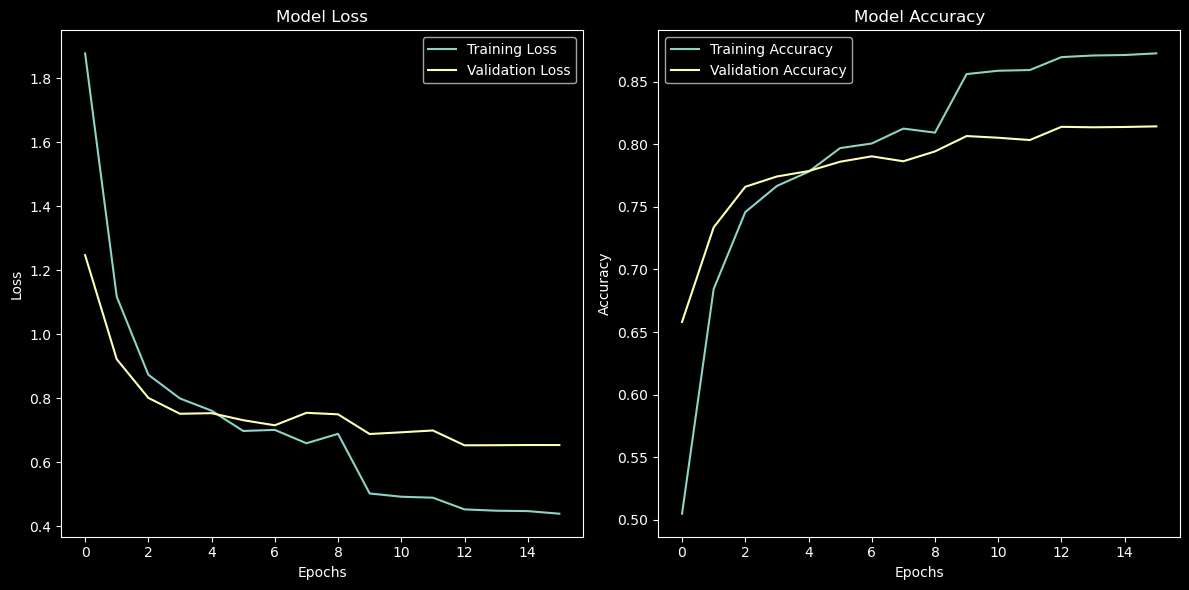

In [26]:
# plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


In [31]:
# Plot ROC AUC for each class (one-vs-rest)
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Get true labels and predicted probabilities for the validation set
y_true = []
y_score = []

for images, labels in test_ds:
    y_true.append(labels.numpy())
    y_score.append(model.predict(images))

y_true = np.concatenate(y_true)
y_score = np.concatenate(y_score)

# Compute ROC AUC for each class
n_classes = y_true.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_score[:, i])


1/1 [==============================] - 0s 27ms/step


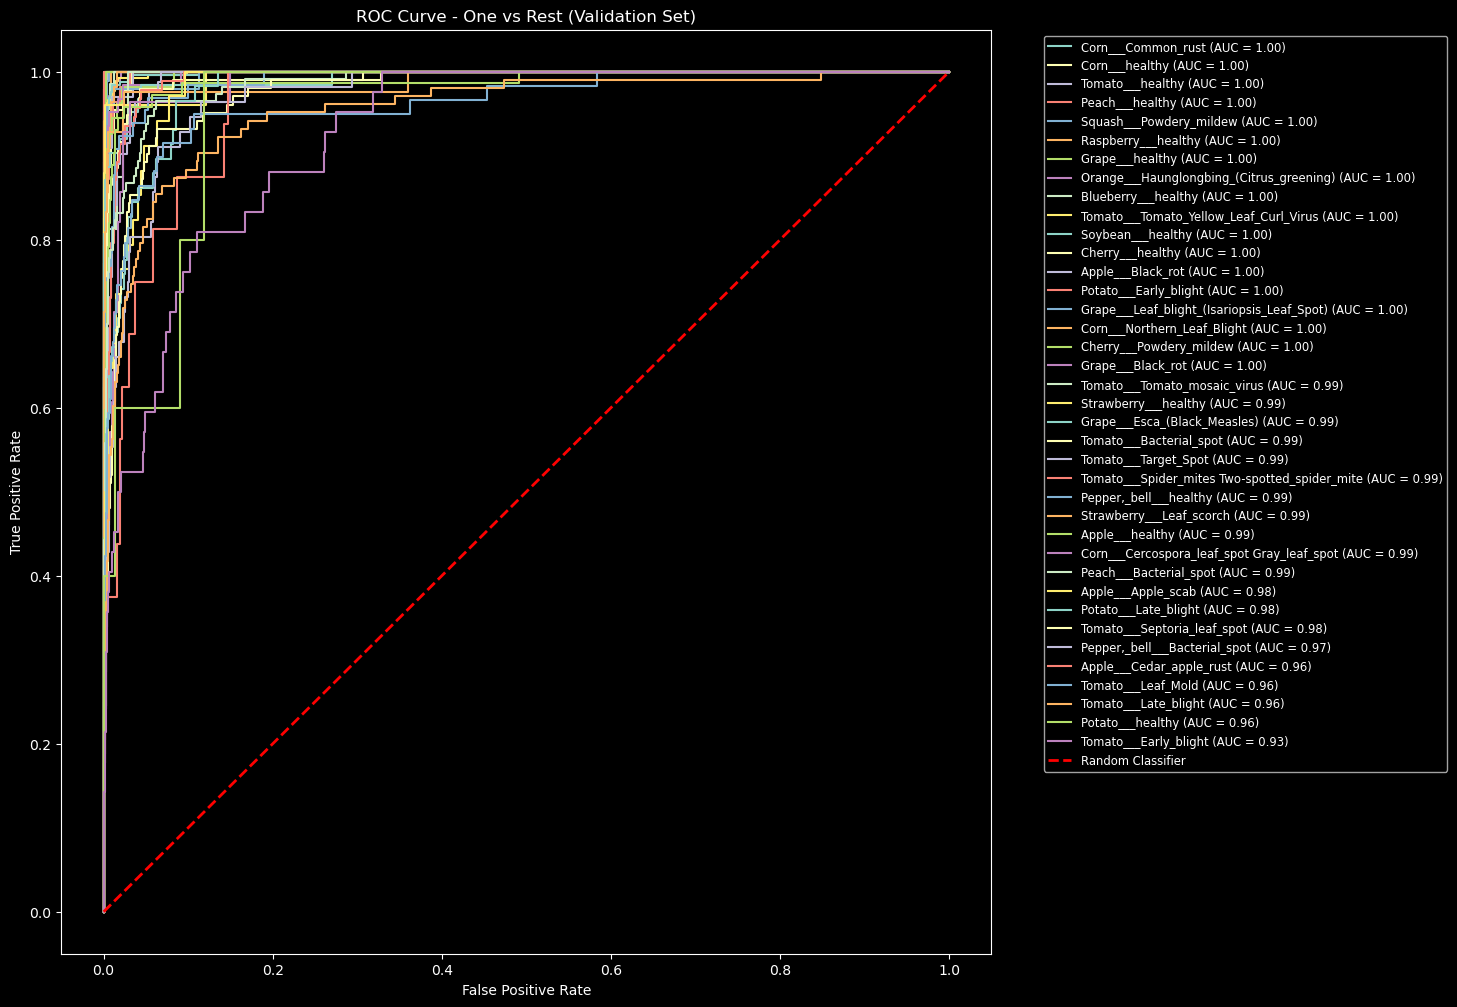

In [ ]:
# Plot ROC curve for each class, legend sorted by AUC score
plt.figure(figsize=(12, 12))

# Prepare list of (auc, i) and sort descending
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)

for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Validation Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='upper left')


In [33]:
# Plot confusion matrix for the validation set
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get true and predicted labels for the validation set
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred, normalize='true')


1/1 [==============================] - 0s 9ms/step


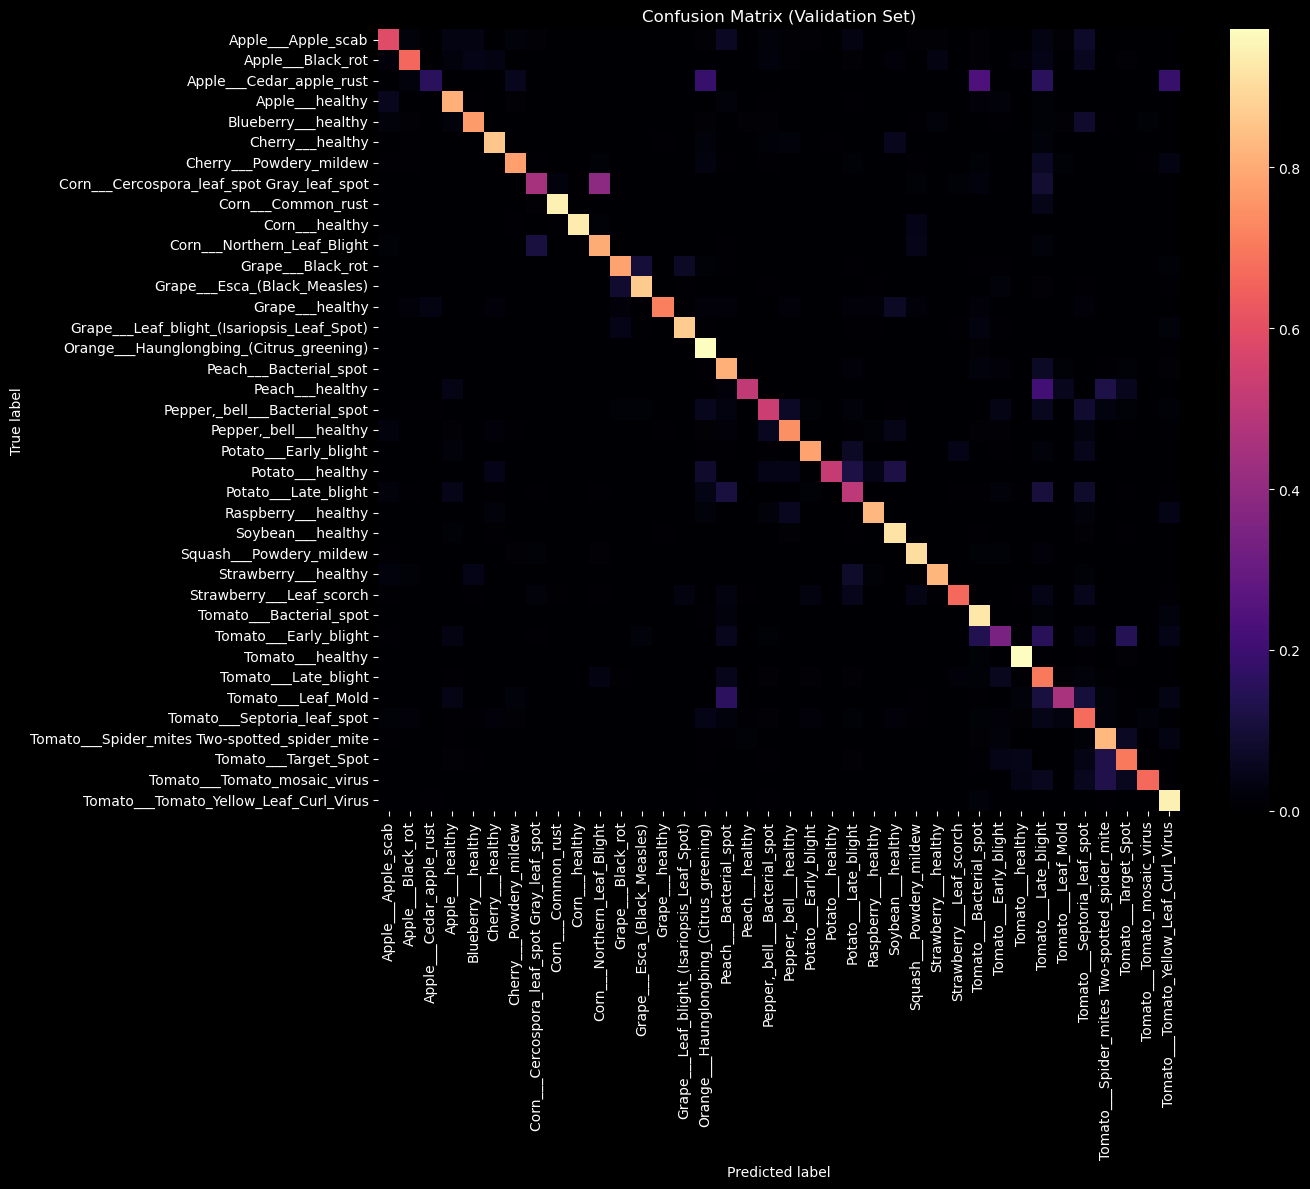

In [34]:
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=False, fmt='d', cmap='magma', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (Validation Set)')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
